In [1]:
%load_ext autoreload
%autoreload all -p -l

! This script is only a showcase for the methodology. For the article a Euler design rainfall type 2 (with a duration of the longest flow time in the network) was used for the simplification.

In [2]:
import pandas as pd

from swmm_api import SwmmInput, CONFIG
from swmm_api.input_file.macros import *

from swmm_model_simplification.simplifying_model import aggregate_model

In [3]:
CONFIG['exe_path'] = "/Users/markus/.bin/runswmm"

In [4]:
inp = SwmmInput('model_bellinge.inp')
set_crs(inp, 'EPSG:25832')

what are the differences to the original model. 

conversion of m3/s to L/s

set only one rain gauge

In [5]:
inp_orig = SwmmInput('/Users/markus/PycharmProjects/swmm_api/examples/Bellinge/BellingeSWMM_v021_nopervious.inp')
print(compare_inp_objects(inp_orig, inp))

compare_inp_objects:   0%|          | 0/28 [00:00<?, ?it/s]


####################################################################################################
[OPTIONS]
not equal (7): 
    FLOW_UNITS: CMS != LPS
    LENGTHENING_STEP: 0 != 1
    MAX_TRIALS: 20 != 24
    MINIMUM_STEP: 0.2 != 0.1
    ROUTING_STEP: 0:00:04 != 5
    THREADS: 2 != 1
    VARIABLE_STEP: 0.65 != 0.75
26/33 objects are equal

####################################################################################################
[RAINGAGES]
not in inp1 (1): RG
not in inp2 (2): rg5425 | rg5427
0/3 objects are equal

####################################################################################################
[SUBCATCHMENTS]
not equal (713): 
    rain_gage=(rg5425 != RG): (n=545)['BellAa_1358_17896_6', 'G70F163_7689', 'G70F164_7690', 'G70F165_7691', 'G70F166_7692', 'G70F210_7693', 'G70F211_7694', 'G70F220_7695', 'G70F230_7696', 'G70F232_7697', 'G70F234_7698', 'G70F235_7699', 'G70F236_7700', 'G70F335_7706', 'G70R193_7763', 'G71F041_7827', 'G71F041_7828', 'G71F046_7829

In [6]:
print_summary(inp)

ROUTING_STEP: 5
NODES: 1_020
   JUNCTIONS: 995
   STORAGE: 16
   OUTFALLS: 9
LINKS: 1_044
   CONDUITS: 1015
   WEIRS: 13
   OUTLETS: 7
   ORIFICES: 3
SUBCATCHMENTS: 713


# Plotting with Matplotlib

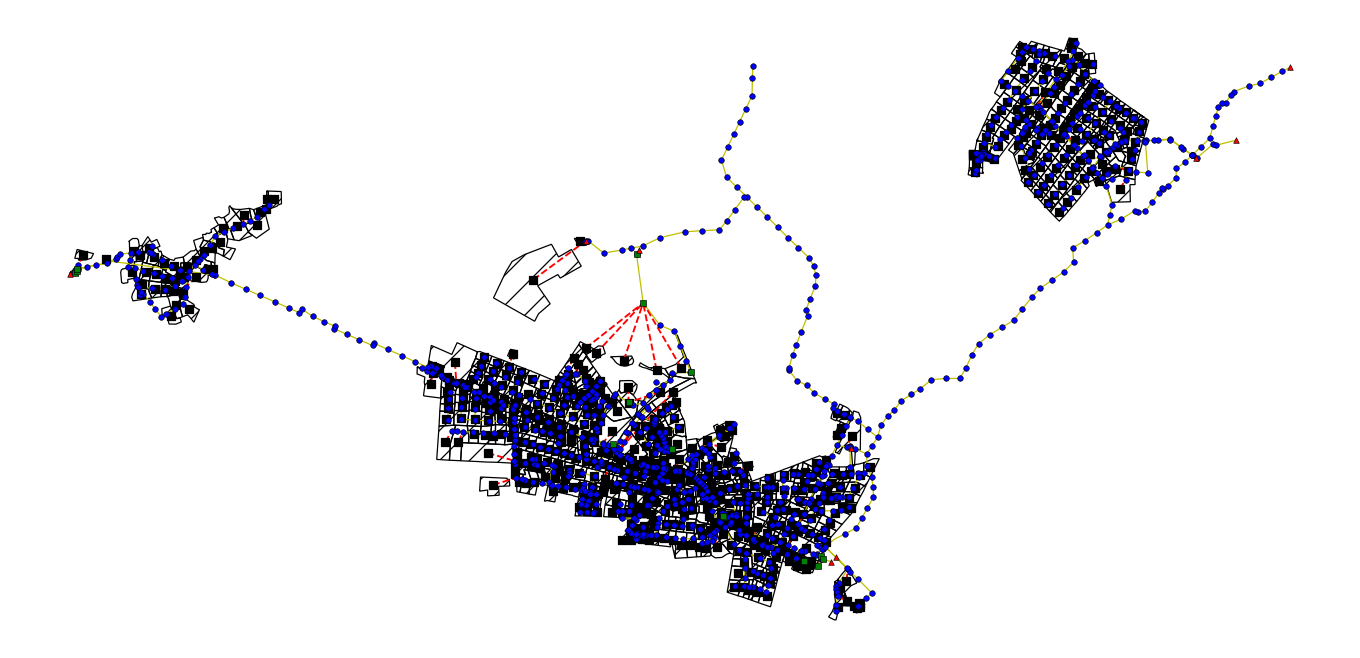

In [24]:
from swmm_api.input_file.macros.plotting_map import plot_map
fig, ax = plot_map(inp)
fig.set_size_inches(15,15)
fig.set_dpi(90)

# Plotting with Plotly

In [8]:
# from swmm_api.input_file.macros.plotting_map_plotly import init_empty_map_plot, add_link_map, add_node_map, add_subcatchment_map
# fig = init_empty_map_plot()
# add_subcatchment_map(fig, inp)
# add_link_map(fig, inp)
# add_node_map(fig, inp)
# fig.layout.update(height=500, width=1000)
# fig.layout.autosize = True
# fig.write_html('model.html')
# fig

# Plotting with Leaflet

In [9]:
# from swmm_api.input_file.macros.plotting_map_leaflet import plot_map
# m = plot_map(inp)
# m.save('map_interactive_leaflet.html')
# m

setting up logging

In [10]:
import logging

logger = logging.getLogger('simplify bellinge')
logger.setLevel(logging.ERROR)

# logging.basicConfig(filename=os.path.join(PATH_CHANGES_LOG, 'flows.log'))

fmt = logging.Formatter('[%(asctime)s] %(message)s')

# log to the console/terminal
# import sys
# console_handler = logging.StreamHandler(sys.stderr)
# console_handler.setFormatter(fmt)
# logger.addHandler(console_handler)

# log to a file
file_handler = logging.FileHandler('log_simplify_bellinge.txt', mode='w', encoding='utf-8')
file_handler.setFormatter(fmt)
logger.addHandler(file_handler)

import warnings
warnings.showwarning = lambda message, category, filename, lineno, file=None, line=None: logger.warning(str(message))

In [11]:
help(aggregate_model)

Help on function aggregate_model in module swmm_model_simplification.simplifying_model:

aggregate_model(inp_hd, area_min, length_max, skip_optimisation=False, optimize_volume=True, optimize_flow_full=True, optimize_flow_full_ratio=False, write_sc_transformation_as_tag=False, logging_func=None)
    Simplifies SWMM model using the preset rainfall. Auto-calibrated based on flow rate.

    Tested on small rainfall event with no flooding.

    Preparation:
        - set rain for raingauges TIMESERIES, RAINGAUGES, SUBCATCHMENTS
        - set times for rain in OPTIONS
        - set report start for start time of calibration time range for the NSE in OPTIONS
        - set simulation options - routing step, ...

    Args:
        inp_hd (SwmmInput): SWMM input data.
        area_min (int | float): minimum aggregated area for one SC which should stay in the model at the boundary of the network.
        length_max (int | float): longest path to combine into one conduit. If the path is longer, ma

In [12]:
# set rain for raingauges TIMESERIES, RAINGAUGES, SUBCATCHMENTS
# set times for rain in OPTIONS
# set simulation options - routing step, ...
inp.OPTIONS.set_routing_step(5)
inp.OPTIONS.set_variable_step(0.75)
inp.OPTIONS.set_lengthening_step(1)
inp.OPTIONS.set_minimum_step(0.1)
inp.OPTIONS.set_max_trials(24)
inp.OPTIONS.set_threads(1)

from swmm_api.input_file.sections import RainGage, TimeseriesData
ts = TimeseriesData('block_rain', [(0, 0), (1, 20)])
inp.add_obj(ts)

rg = RainGage(name='RG', form=RainGage.FORMATS.VOLUME, interval='1:00',
                     SCF=1, source=RainGage.SOURCES.TIMESERIES, timeseries=ts.name)
inp.add_obj(rg)

for sc in inp.SUBCATCHMENTS:
    inp.SUBCATCHMENTS[sc].rain_gage = rg.name

inp.OPTIONS.set_start(pd.Timestamp.today().replace(minute=0, second=0, hour=0, microsecond=0, nanosecond=0))
inp.OPTIONS.set_report_start(inp.OPTIONS.get_start() + pd.Timedelta(hours=1))
inp.OPTIONS.set_simulation_duration(pd.Timedelta(hours=2))

In [13]:
from swmm_api.run_swmm.run_temporary import swmm5_run_temporary
from swmm_model_simplification.helpers.config import CONFIG
with swmm5_run_temporary(inp.copy(), run=CONFIG["SWMM_runner"]) as res:
    out = res.out
    rpt = res.rpt

In [14]:
rpt.flow_routing_continuity

{'Dry Weather Inflow': {'Volume_hectare-m': 0.006, 'Volume_10^6 ltr': 0.063},
 'Wet Weather Inflow': {'Volume_hectare-m': 1.527, 'Volume_10^6 ltr': 15.266},
 'Groundwater Inflow': {'Volume_hectare-m': 0.0, 'Volume_10^6 ltr': 0.0},
 'RDII Inflow': {'Volume_hectare-m': 0.0, 'Volume_10^6 ltr': 0.0},
 'External Inflow': {'Volume_hectare-m': 0.0, 'Volume_10^6 ltr': 0.0},
 'External Outflow': {'Volume_hectare-m': 0.542, 'Volume_10^6 ltr': 5.425},
 'Flooding Loss': {'Volume_hectare-m': 0.07, 'Volume_10^6 ltr': 0.697},
 'Evaporation Loss': {'Volume_hectare-m': 0.0, 'Volume_10^6 ltr': 0.0},
 'Exfiltration Loss': {'Volume_hectare-m': 0.0, 'Volume_10^6 ltr': 0.0},
 'Initial Stored Volume': {'Volume_hectare-m': 0.0, 'Volume_10^6 ltr': 0.0},
 'Final Stored Volume': {'Volume_hectare-m': 0.859, 'Volume_10^6 ltr': 8.59},
 'Continuity Error (%)': 4.028}

In [15]:
inp_simple = aggregate_model(inp, area_min=5, length_max=400, logging_func=None)

simplify model - iter over all nodes:   0%|          | 0/1020 [00:00<?, ?it/s]

In [16]:
print_summary(inp_simple)

ROUTING_STEP: 5
NODES: 133
   JUNCTIONS: 108
   STORAGE: 16
   OUTFALLS: 9
LINKS: 156
   CONDUITS: 127
   WEIRS: 13
   OUTLETS: 7
   ORIFICES: 3
SUBCATCHMENTS: 66


In [17]:
# from swmm_api.input_file.macros.plotting_map_leaflet import plot_map
# set_crs(inp_simple, 'EPSG:25832')
# m = plot_map(inp_simple)
# m.save('map_interactive_leaflet.html')
# m

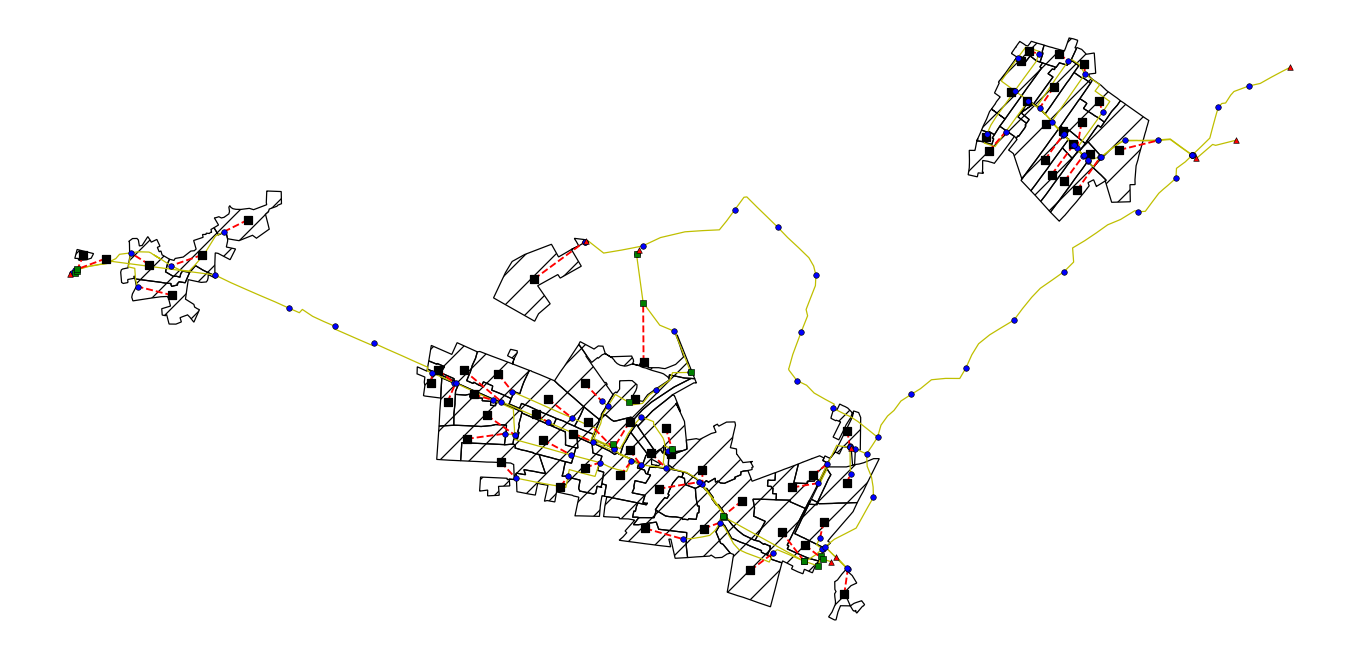

In [23]:
from swmm_api.input_file.macros.plotting_map import plot_map
fig, ax = plot_map(inp_simple)
fig.set_size_inches(15,15)
fig.set_dpi(90)